In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, qeye, sigmax, sigmay, sigmaz, mesolve, entropy_vn

In [5]:
def generate_operators_qutip(N):
    sx_list = []
    sy_list = []
    sz_list = []
    p_list = []

    for n in range(N):
        ops = [qeye(2)] * N
        ops[n] = sigmax()
        sx_list.append(tensor(ops))
        
        ops[n] = sigmay()
        sy_list.append(tensor(ops))
        
        ops[n] = sigmaz()
        sz_list.append(tensor(ops))
        
        ops[n] = (qeye(2) - sigmaz()) / 2
        p_list.append(tensor(ops))
    
    return sx_list, sy_list, sz_list, p_list

def create_PXP_Hamiltonian(N, W, Omega, Bound):
    sx_list, sy_list, sz_list, p_list = generate_operators_qutip(N)

    H = 0
    for n in range(N - 2):
        H += Omega* p_list[n] * sx_list[n + 1] * p_list[n + 2]

    # Boundary conditions
    if Bound.lower() == 'pbc':
        H += Omega*(p_list[N - 2] * sx_list[N - 1] * p_list[0] + p_list[N - 1] * sx_list[0] * p_list[1])  # PBC

    if Bound.lower() == 'obc':
        H += Omega*(sx_list[0] * p_list[1] + p_list[N - 2] * sx_list[N - 1])  # OBC

    # Random uniform distribution of perturbation strength values
    hw = np.random.uniform(-W / 2, W / 2, (3 * N))
    m = 0
    for n in range(N):
        H += hw[m] * sx_list[n] + hw[m + 1] * sy_list[n] + hw[m + 2] * sz_list[n]  # Perturbing all directions
        m += 3
    
    return H

In [51]:
# Define the initial Z2 state with excitation on every other site
def Z2_state(N):
    return tensor([basis(2, i % 2) for i in range(N)])

# Define the translated Z2 state with excitation on every other site, but shifted
def translated_Z2_state(N):
    return tensor([basis(2, (i + 1) % 2) for i in range(N)])

# Create the superposition of Z2 and translated Z2 states
def superposition_Z2_translated_Z2(N):
    Z2 = Z2_state(N)
    translated_Z2 = translated_Z2_state(N)
    superposition = (Z2 + translated_Z2).unit() / np.sqrt(2)
    return superposition

def Z0_state(N):
    return tensor([basis(2, 0) for i in range(N)])

def Z3_state(N):
    return tensor([basis(2, (i % 3 == 2)) for i in range(N)])

def Z4_state(N):
    return tensor([basis(2, (i % 4 == 3)) for i in range(N)])

In [75]:
def entanglement_entropy_qutip(state, N):
    # Trace out half of the system to get the reduced density matrix
    return entropy_vn(state.ptrace(list(range(N//2))))

def compute_EE_evolution_Z2(N, W, Omega, Bound, times):
    H = create_PXP_Hamiltonian(N, W, Omega, Bound)
    initial_state = Z2_state(N)
    result = mesolve(H, initial_state, times, [], [])
    entropies = [entanglement_entropy_qutip(state, N) for state in result.states]
    return entropies

def compute_EE_evolution_Z0(N, W, Omega, Bound, times):
    H = create_PXP_Hamiltonian(N, W, Omega, Bound)
    initial_state = Z0_state(N)
    result = mesolve(H, initial_state, times, [], [])
    entropies = [entanglement_entropy_qutip(state, N) for state in result.states]
    return entropies

def compute_EE_evolution_Z3(N, W, Omega, Bound, times):
    H = create_PXP_Hamiltonian(N, W, Omega, Bound)
    initial_state = Z3_state(N)
    result = mesolve(H, initial_state, times, [], [])
    entropies = [entanglement_entropy_qutip(state, N) for state in result.states]
    return entropies

def compute_EE_evolution_Z4(N, W, Omega, Bound, times):
    H = create_PXP_Hamiltonian(N, W, Omega, Bound)
    initial_state = Z4_state(N)
    result = mesolve(H, initial_state, times, [], [])
    entropies = [entanglement_entropy_qutip(state, N) for state in result.states]
    return entropies

def compute_EE_evolution_transZ2(N, W, Omega, Bound, times):
    H = create_PXP_Hamiltonian(N, W, Omega, Bound)
    initial_state = translated_Z2_state(N)
    result = mesolve(H, initial_state, times, [], [])
    entropies = [entanglement_entropy_qutip(state, N) for state in result.states]
    return entropies

def compute_EE_evolution_supZ2(N, W, Omega, Bound, times):
    H = create_PXP_Hamiltonian(N, W, Omega, Bound)
    initial_state = superposition_Z2_translated_Z2(N)
    result = mesolve(H, initial_state, times, [], [])
    entropies = [entanglement_entropy_qutip(state, N) for state in result.states]
    return entropies

# Example parameters
N = 14 # Small chain size
Omega = 1.0
W = 0.9
Bound = 'PBC'
times = np.linspace(0, 20, 200)

entropiesZ04 = compute_EE_evolution_Z0(N, W, Omega, Bound, times)
#entropiesZ21 = compute_EE_evolution_Z2(N, W, Omega, Bound, times)
#entropiestransZ2 = compute_EE_evolution_transZ2(N, W, Omega, Bound, times)
#entropiessupZ2 = compute_EE_evolution_supZ2(N, W, Omega, Bound, times)
# entropiesZ3 = compute_EE_evolution_Z3(N, W, Omega, Bound, times)
# entropiesZ4 = compute_EE_evolution_Z4(N, W, Omega, Bound, times)

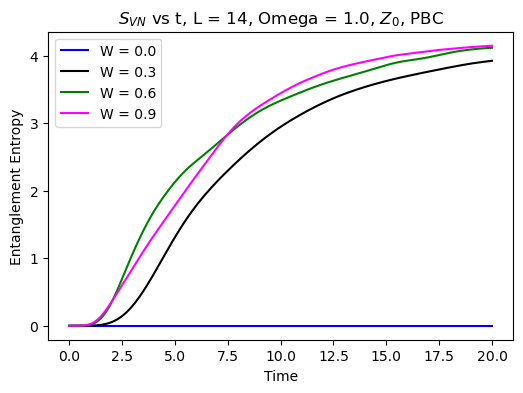

In [79]:
plt.figure(figsize=(6, 4))
plt.plot(times, entropiesZ01, label = "W = 0.0", color = 'blue')
plt.plot(times, entropiesZ02, label = "W = 0.3", color = 'black')
plt.plot(times, entropiesZ03, label = "W = 0.6", color = 'green')
plt.plot(times, entropiesZ04, label = "W = 0.9", color = 'magenta')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('$S_{VN}$ vs t, L = 14, Omega = 1.0, $Z_{0}$, PBC', fontsize = 12)
plt.legend()
plt.show()

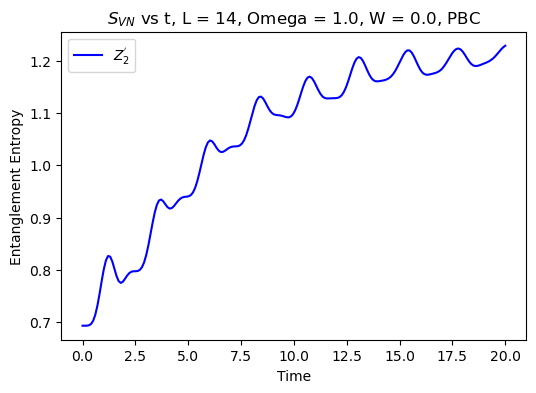

In [71]:
plt.figure(figsize=(6, 4))
plt.plot(times, entropiessupZ2, label = "$Z^{'}_{2}$", color = 'blue')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('$S_{VN}$ vs t, L = 14, Omega = 1.0, W = 0.0, PBC', fontsize = 12)
plt.legend()
plt.show()

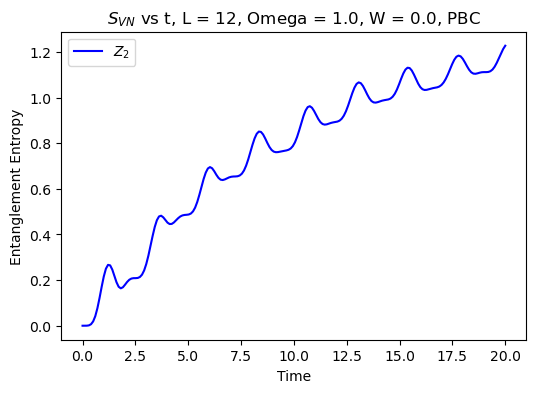

In [66]:
plt.figure(figsize=(6, 4))
plt.plot(times, entropiesZ2, label = '$Z_{2}$', color = 'blue')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('$S_{VN}$ vs t, L = 12, Omega = 1.0, W = 0.0, PBC', fontsize = 12)
plt.legend()
plt.show()

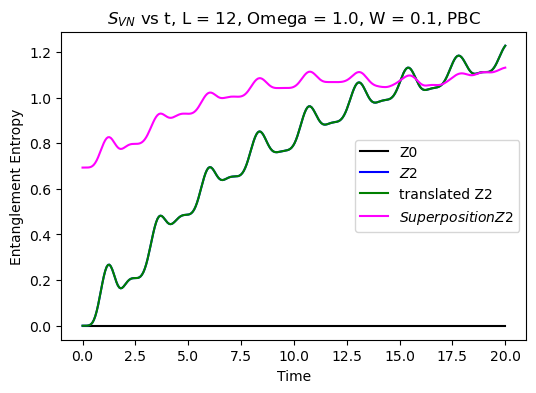

In [64]:
plt.figure(figsize=(6, 4))
plt.plot(times, entropiesZ0, label = 'Z0', color = 'black')
plt.plot(times, entropiesZ2, label = '$Z2$', color = 'blue')
plt.plot(times, entropiestransZ2, label = 'translated Z2',color = 'green')
plt.plot(times, entropiessupZ2, label = '$Superposition Z2$', color = 'magenta')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('$S_{VN}$ vs t, L = 12, Omega = 1.0, W = 0.1, PBC', fontsize = 12)
plt.legend()
plt.show()

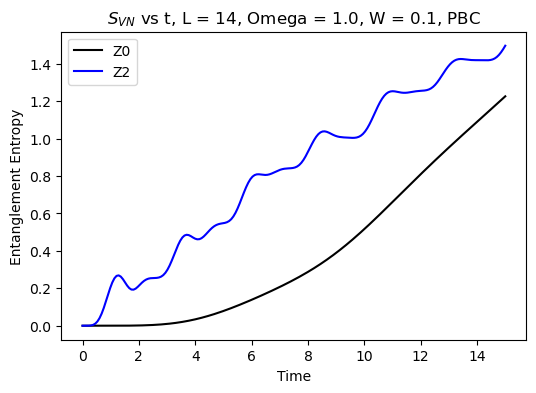

In [56]:
plt.figure(figsize=(6, 4))
plt.plot(times, entropiesZ0, label = 'Z0', color = 'black')
plt.plot(times, entropiesZ2, label = 'Z2', color = 'blue')
# plt.plot(times, entropiesZ3, label = 'Z3',color = 'green')
# plt.plot(times, entropiesZ4, label = 'Z4', color = 'magenta')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('$S_{VN}$ vs t, L = 14, Omega = 1.0, W = 0.1, PBC', fontsize = 12)
plt.legend()
plt.show()

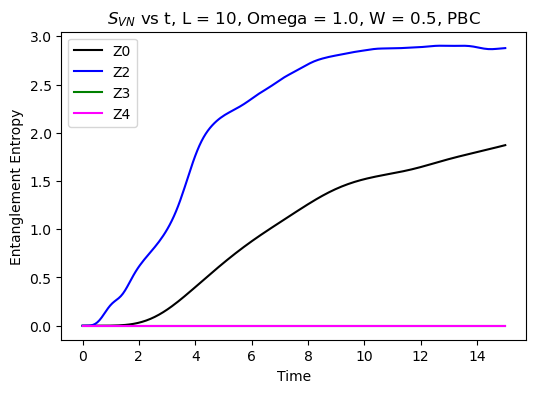

In [53]:
plt.figure(figsize=(6, 4))
plt.plot(times, entropiesZ0, label = 'Z0', color = 'black')
plt.plot(times, entropiesZ2, label = 'Z2', color = 'blue')
plt.plot(times, entropiesZ3, label = 'Z3',color = 'green')
plt.plot(times, entropiesZ4, label = 'Z4', color = 'magenta')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('$S_{VN}$ vs t, L = 10, Omega = 1.0, W = 0.5, PBC', fontsize = 12)
plt.legend()
plt.show()

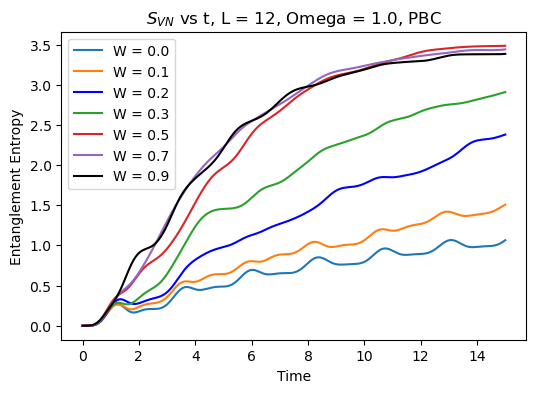

In [47]:
plt.figure(figsize=(6, 4))
plt.plot(times, entropies1, label = 'W = 0.0')
plt.plot(times, entropies5, label = 'W = 0.1')
plt.plot(times, entropies10, label = 'W = 0.2',color = 'blue')
plt.plot(times, entropies8, label = 'W = 0.3')
plt.plot(times, entropies6, label = 'W = 0.5')
plt.plot(times, entropies9, label = 'W = 0.7')
plt.plot(times, entropies7, label = 'W = 0.9',color = 'black')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('$S_{VN}$ vs t, L = 12, Omega = 1.0, PBC', fontsize = 12)
plt.legend()
plt.show()

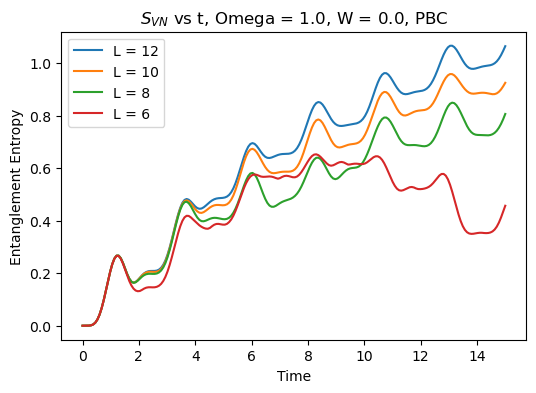

In [35]:
plt.figure(figsize=(6, 4))
plt.plot(times, entropies1, label = 'L = 12')
plt.plot(times, entropies2, label = 'L = 10')
plt.plot(times, entropies3, label = 'L = 8')
plt.plot(times, entropies4, label = 'L = 6')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('$S_{VN}$ vs t, Omega = 1.0, W = 0.0, PBC', fontsize = 12)
plt.legend()
plt.show()

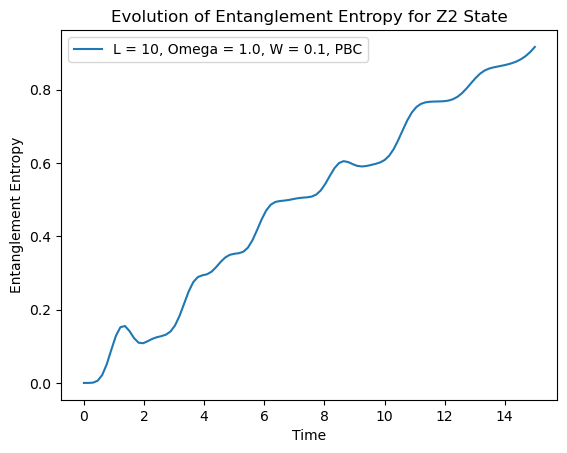

In [14]:
plt.plot(times, entropies1, label = 'L = 10, Omega = 1.0, W = 0.1, PBC')
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.title('Evolution of Entanglement Entropy for Z2 State')
plt.legend()
plt.show()